# Lab 07: Support Vector Machines

Today we'll look at the SVM maximum margin classification problem and how we can implement the optimization
in Python.

We'll use the cvxopt quadratic programming optimizer in Python.

Later in the lectures, we'll see that more specialized algorithms such as Sequential Minimal Optimization
implemented by the machine learning libraries are more effective for large SVM problems.

## Linearly separable case: direct solution using quadratic programming

If we assume that the data are linearly separable, we can use the following setup for the optimization:
- The data are pairs $(\mathbf{x}^{(i)},y^{(i)})$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and $y^{(i)} \in \{-1,1\}$.
- The hypothesis is
  $$h_{\mathbf{w},b}(\mathbf{x}) = \begin{cases} 1 & \text{if} \; \mathbf{w}^\top \mathbf{x} + b > 0 \\ -1 & \text{otherwise} \end{cases}$$
- The objective function is
  $$\mathbf{w}^*,b^* = \mathrm{argmax}_{\mathbf{w},b} \gamma,$$
  where $\gamma$ is the minimum geometric margin for the training data:
  $$\gamma = \min_i \gamma^{(i)}$$
  and $\gamma^{(i)}$ is the geometric margin for training example $i$, i.e., the signed distance of $\mathbf{x}^{(i)}$ from the decision boundary,
  with positive distances indicating that the point is on the correct side of the boundary and negative distances indicating that the point is on the
  incorrect side of the boundary:
  $$\gamma^{(i)} = y^{(i)}\left( \left( \frac{\mathbf{w}}{\|\mathbf{w}\|} \right)^\top \mathbf{x}^{(i)} + \frac{b}{\| \mathbf{w}\|} \right). $$
- To find the optimal $\mathbf{w},b$ according to the objective function above, we can solve the constrained
  optimization problem
  $$ \begin{array}{rl} \min_{\mathbf{w},b} & \|\mathbf{w}\| \\
                     \text{subject to} & y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b)\ge 1, i \in 1..m
   \end{array}
  $$



## Exercise 1 (in lab): linearly separable data

Take the example data and SVM optimization code using cvxopt from the exercise in lecture. Verify that you can find the decision boundary for such "easy" cases.
Show your results in your lab report.




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cvxopt

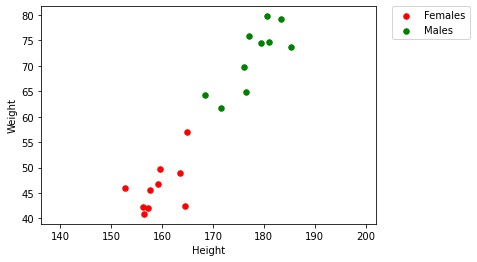

In [3]:
# Example data
Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 157.308, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  42.150,  49.739 ]]).T;

Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;

X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

#Plots
def plot_mf(Xf,Xm):
    axes = plt.axes()
    females_series = plt.scatter(np.array(Xf[:,0]), np.array(Xf[:,1]), s=30, c='r', marker='o', label='Females')
    males_series = plt.scatter(np.array(Xm[:,0]), np.array(Xm[:,1]), s=30, c='g', marker='o', label='Males')
    axes.set_aspect('equal', 'datalim')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend(handles=[females_series, males_series], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return axes

axes = plot_mf(Xf,Xm)

In [4]:
def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

# SVM optimization using cvxopt

Q = np.eye(3);
Q[2,2] = 0;
c = np.zeros([3])
A = np.multiply(np.tile(-y,[1, 3]), np.concatenate([X, np.ones([20,1])],1))
b = -np.ones([20])
x = cvxopt_solve_qp(Q, c, A, b);
w = np.matrix([[x[0]],[x[1]]]);
b = x[2];
scale = np.linalg.norm(w);
w = w / scale;
b = b / scale;
print('Optimal w: [%f %f] b: %f' % (w[0,0],w[1,0],b));

     pcost       dcost       gap    pres   dres
 0:  1.4721e-03  6.5053e+00  5e+01  2e+00  4e+02
 1:  1.0012e-02 -4.7161e+00  1e+01  6e-01  1e+02
 2:  2.6180e-02 -4.8172e+00  7e+00  2e-01  6e+01
 3:  3.9767e-02 -4.5363e-01  5e-01  1e-02  2e+00
 4:  3.5404e-02  1.8200e-02  2e-02  5e-15  9e-14
 5:  3.1392e-02  3.0877e-02  5e-04  5e-15  6e-13
 6:  3.1250e-02  3.1245e-02  5e-06  6e-15  2e-13
 7:  3.1249e-02  3.1248e-02  5e-08  5e-15  2e-13
Optimal solution found.
Optimal w: [0.640061 0.768324] b: -153.309495


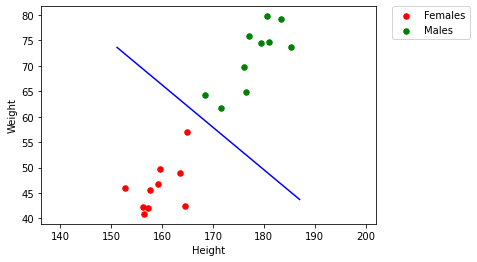

In [5]:
# plotting decision boundary
def plot_w(w, b, axes):
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'b-')

axes = plot_mf(Xf, Xm)
plot_w(w, b, axes)

We can easily find decision boundary for such "easy case"

## Exercise 2 (in lab): non-separable data

Take the example of the annulus from the logistic regression lab. Verify that cvxopt cannot find a decision boundary for this case. Show your results in your
lab report.

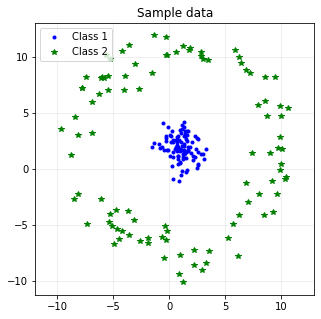

In [6]:
# Generate data for class 1
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset
X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))
y = y.reshape(2*num_sample, 1)

fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample data')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [7]:
# Similar optimization with cvxopt
Q = np.eye(3);
Q[2,2] = 0;
c = np.zeros([3])
A = np.multiply(np.tile(-y,[1, 3]), np.concatenate([X, np.ones([200,1])],1))
b = -np.ones([200])
x = cvxopt_solve_qp(Q, c, A, b);

     pcost       dcost       gap    pres   dres
 0:  1.0539e-34  2.0000e+02  4e+02  2e+00  2e+02
 1:  2.7905e-34  4.4777e+02  1e+02  1e+00  1e+02
 2:  2.7262e-34  5.0336e+04  1e+02  1e+00  1e+02
 3:  2.7195e-34  4.9894e+08  6e+02  1e+00  1e+02
 4:  2.7195e-34  4.9395e+14  5e+06  1e+00  1e+02
 5:  2.7195e-34  4.8901e+22  5e+12  1e+00  1e+02
 6:  2.7195e-34  4.8412e+32  5e+20  1e+00  1e+02
 7:  2.7195e-34  4.7932e+44  5e+30  1e+00  1e+02
 8:  2.7195e-34  4.7955e+58  5e+42  1e+00  1e+02
 9:  2.7195e-34  1.9554e+74  2e+56  1e+00  1e+02
10:  1.5100e-32  1.9358e+110  2e+92  7e-01  1e+00
11:  1.8193e-32  1.9165e+146  3e+148  1e+02  1e-02
12:  3.6374e-35  1.9417e+146  3e+146  2e+00  2e-04
13:  6.0003e-36  3.9937e+146  6e+144  7e-01  7e-05
14:  5.8271e-36  2.7170e+148  4e+144  7e-01  7e-05
15:  5.8254e-36  1.7953e+152  3e+146  7e-01  7e-05
16:  5.8254e-36  1.1860e+158  2e+150  7e-01  7e-05
17:  5.1762e-09  1.1860e+158  2e+150  7e-01  7e-05
18:  4.6788e-09  1.1860e+158  2e+150  7e-01  7e-05
19: 

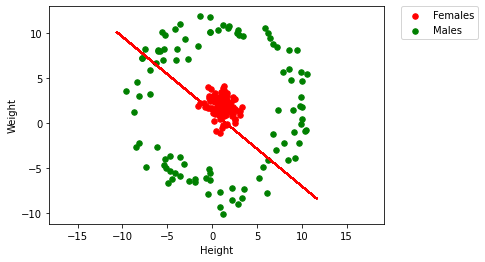

In [8]:
def plot_w(w, b, axes):
    ylim = axes.get_ylim()
    xlim = axes.get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

axes = plot_mf(X1, X2)
plot_w(w, b, axes)

We cannot find the decision boundary for above case

## Generalized Lagrangian optimization for SMVs

Now we consider the generalized Lagrangian for the SVM. This technique is suitable for solving problems of the form
  $$ \begin{array}{rl}
    \min_{\mathbf{w}} & f(\mathbf{w}) \\
    \text{subject to} & g_i(\mathbf{w}) \le 0, i \in 1..k \\
                      & h_i(\mathbf{w}) = 0, i \in 1..l
   \end{array}$$

The generalized Lagrangian is
$$\cal{L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta}) = f(\mathbf{w}) + \sum_{i=1}^k \alpha_i g_i(\mathbf{w}) + \sum_{i=1}^l \beta_i h_i(\mathbf{w}),$$
which has been cleverly arranged to be equal to $f(\mathbf{w})$ whenever $\mathbf{w}$ satisfies the constraints and $\infty$ otherwise.

### Primal and dual Lagrangian problems

The primal problem is to find
$$p^* = \min_{\mathbf{w}}\theta_{\cal P}(\mathbf{w}) = \min_\mathbf{w}\max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} {\cal L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta})$$
and the dual problem is to find
$$d^* = \max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} \theta_{\cal D}(\mathbf{\alpha},\mathbf{\beta}) =  \max_{\mathbf{\alpha},\mathbf{\beta},\alpha_i \ge 0} \min_\mathbf{w}{\cal L}(\mathbf{w},\mathbf{\alpha},\mathbf{\beta}).$$
If $f$ is convex, the $g_i$'s are affine, the $h_i$'s are convex, and the $g_i$'s are strictly
feasible, it turns out that the solutions to the primal and dual problem are the same, and the KKT conditions hold:
$$ \begin{array}{rcl}
  \frac{\partial}{\partial w_i}{\cal L}(\mathbf{w}^*,\mathbf{\alpha}^*,\mathbf{\beta}^*) & = & 0, i \in 1..n \\
  \frac{\partial}{\partial \beta_i}{\cal L}(\mathbf{w}^*,\mathbf{\alpha}^*,\mathbf{\beta}^*) & = & 0, i \in 1..l \\
  \alpha_i^*g_i(\mathbf{w}^*) & = & 0, i \in 1..k \\
  g_i(\mathbf{w}^*) & \le & 0, i \in 1..k \\
  \alpha_i^* & \ge & 0, i \in 1..k
  \end{array} $$

### Solving the dual Lagrangian problem

The dual problem turns out to be easiest to solve.

We first solve for $\mathbf{w}$ assuming fixed $\mathbf{\alpha}$ and $\mathbf{\beta}$ (we don't have equality constraints though, so no need for $\mathbf{\beta}$).

We need to rewrite the SVM constraints in the necessary form with $g_i(\mathbf{w})=0$.obtain, for the SVM, constraints
$$g_i(\mathbf{w},b) = -y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)} + b) + 1 \ge 0.$$
Using that definition of $g_i(\mathbf{w},b)$, we obtain the Lagrangian
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{i=1}^m\alpha_i\left[ y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)} + b) -1 \right] $$
Taking the gradient of ${\cal L}$ with respect to $\mathbf{w}$ and setting it to 0, we obtain

$$\nabla_\mathbf{w}{\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \mathbf{w} - \sum_{i=1}^m\alpha_i y^{(i)} \mathbf{x}^{(i)} = 0,$$
which gives us

$$\mathbf{w}=\sum_{i=1}^m\alpha_i y^{(i)} \mathbf{x}^{(i)}.$$

From $\frac{\partial {\cal L}}{\partial b} = 0$, we obtain
$$\sum_{i=1}^m \alpha_i y^{(i)} = 0,$$
which is interesting (think about what it means also considering that $\alpha_i > 0$ only for examples on the margin.
Unfortunately it doesn't help us find $b$! In any case, we plug this definition for the optimal $\mathbf{w}$ into the original Lagrangian,
to obtain
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j (\mathbf{x}^{(i)})^\top\mathbf{x}^{(j)} - b\sum_{i=1}^m \alpha_i y^{(i)}. $$
We already know that the last term is 0, so we get
$${\cal L}(\mathbf{w},b,\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \left< \mathbf{x}^{(i)},\mathbf{x}^{(j)} \right> . $$
OK! We've eliminated $\mathbf{w}$ and $b$ from the optimization. Now we just need to maximize ${\cal L}$ with respect to $\mathbf{\alpha}$.
This gives us the final (dual) optimization problem
$$ \begin{array}{rl}
  \max_{\mathbf{\alpha}} & W(\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right> \\
  \text{such that} & \alpha_i \ge 0, i \in 1..m \\
                   & \sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{array} $$
This turns out to be QP again!

Aside: once we solve for $\mathbf{\alpha}$, we obtain $\mathbf{w}$ according to the equation above, then it turns out that the optimal $b$ can be obtained as in
the lecture notes.

### QP solution to dual problem

We need to negate our objective function to turn the max (SVM formulation) into a min (QP formalation).

For the second term of $W(\mathbf{\alpha})$, first let $\mathtt{K}$ be the kernel matrix with $\mathtt{K}_{ij} = \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right>$. Then $\mathbf{\alpha}^\top \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \mathbf{\alpha}$ gives us the summation in the second term ($\text{diag}(\mathbf{y})$ is just the square diagonal matrix with $\mathbf{y}$ as its diagonal).

The (negated) first term of $W(\mathbf{\alpha})$ can be written in QP form with $\mathbf{c} = \begin{bmatrix} -1 & -1 & \ldots \end{bmatrix}^\top$.

So that gives us our QP setup:
$$ \mathtt{Q} = \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \; \; \;
   \mathbf{c} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

$$\mathtt{A} = -\mathtt{I}_{m\times m} \;\;\;
  \mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ \vdots \end{bmatrix} $$

$$\mathtt{E} = \mathbf{y}^\top \;\;\;
  \mathbf{d} = \begin{bmatrix} 0 \end{bmatrix}. $$


## Exercise 3 (in lab): linearly separable data

Take the example data from the exercise in lecture. Verify that you can use the dual optmization to find the decision boundary for such "easy" cases.
Show your results in your lab report.

In [9]:
Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 157.308, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  42.150,  49.739 ]]).T;

Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;

X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

In [10]:
# Dual Optimization

m = X.shape[0];
n = X.shape[1];

# Transform data set so that each attribute has a
# mean of 0 and a standard deviation of 1

def preprocess(X):
    means = X.mean(0);
    scales = 1/np.std(X,0);
    Xh = np.concatenate([X.T,np.ones([1,20])],0);
    Tm = np.matrix(np.eye(3));
    Tm[0:2,2:3] = -X.mean(0).T;
    Ts = np.matrix(np.eye(3));
    Ts[0:2,0:2] = np.diagflat(scales);
    T = Ts*Tm;
    XX = (T * Xh);
    XX = XX[0:2,:].T;
    return XX, T;

# RBF/Gaussian kernel

def gauss_kernel(X):
    sigma = 0.2
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]) * (X[i,:] - X[j,:]).T
    K = np.exp(-K/(2*sigma*sigma))      
    return K;

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:]@(X[j,:].T)
    return K;

# Linear kernel below. We might also try
# XX, T = preprocess(X)
# K = gauss_kernel(XX)

K = linear_kernel(X);

Q = np.multiply(y * y.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = -np.eye(m);
b = np.zeros([m]);
E = y.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
print("Optimal alpha:")
print(alpha_star)

def get_wb(X, y, alpha):
    # Find the support vectors
    S = alpha > 1e-6
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

w,b = get_wb(X, y, alpha_star)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -2.7646e+00 -4.9725e+00  5e+01  6e+00  2e+00
 1: -6.4101e+00 -3.8299e+00  1e+01  2e+00  6e-01
 2: -5.0055e+00 -1.2719e+00  7e+00  8e-01  2e-01
 3: -5.1552e-02 -4.0648e-02  5e-01  3e-02  1e-02
 4: -1.8200e-02 -3.5404e-02  2e-02  8e-18  2e-13
 5: -3.0877e-02 -3.1392e-02  5e-04  3e-18  2e-13
 6: -3.1245e-02 -3.1250e-02  5e-06  5e-18  2e-13
 7: -3.1248e-02 -3.1249e-02  5e-08  6e-18  3e-13
Optimal solution found.
Optimal alpha:
[3.12484796e-02 1.13821985e-09 7.68004003e-10 6.22346942e-10
 6.43114906e-10 8.93974185e-10 6.60695981e-10 4.31409827e-10
 6.68557407e-10 1.19689394e-09 1.56332821e-02 1.56151999e-02
 5.00606721e-10 6.71834910e-10 4.89168003e-10 4.93113730e-10
 4.90935291e-10 4.85894510e-10 9.54348935e-10 4.42078646e-10]
Optimal w: [0.640062,0.768324] b: -153.309583


<ipython-input-11-77edf027de16>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ylim = plt.axes().get_ylim()
<ipython-input-11-77edf027de16>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  xlim = plt.axes().get_xlim()


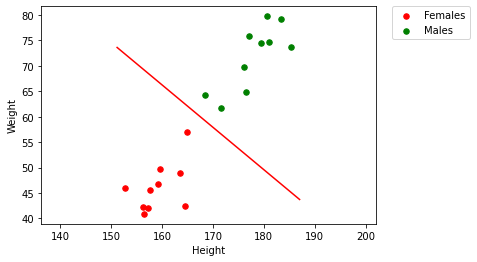

In [11]:
#plotting the decision boundary
def plot_w(w,b):
    ylim = plt.axes().get_ylim()
    xlim = plt.axes().get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

plot_mf(Xf,Xm)
plot_w(w,b)

## Exercise 4 (in lab): non-separable data, linear kernel

Again, take the example of the annulus from the logistic regression lab. Verify that the dual optimization with the linear kernel
still cannot find a decision boundary for this case. Show your results in your
lab report.

In [12]:
#annulus data

# Generate data for class 1
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)


# Generate data for class 2
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T


# Combine X1 and X2 into single dataset
X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))
y = y.reshape(-1, 1)


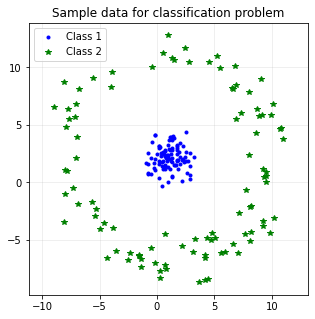

In [13]:
fig1 = plt.figure(figsize=(5,5))
ax = plt.axes() 
plt.title('Sample data for classification problem')
plt.grid(axis='both', alpha=.25)
plt.plot(X1[:,0],X1[:,1],'b.', label = 'Class 1')
plt.plot(X2[:,0],X2[:,1],'g*', label = 'Class 2')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [14]:
m = X.shape[0];
n = X.shape[1];

K = linear_kernel(X);

Q = np.multiply(y * y.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = -np.eye(m);
b = np.zeros([m]);
E = y.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
print("Optimal alpha:")
print(alpha_star)

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -1.0000e+02 -2.0000e+02  4e+02  1e+01  2e+00
 1: -4.4805e+02 -4.5253e+02  1e+02  7e+00  1e+00
 2: -5.0337e+04 -5.0342e+04  1e+02  7e+00  1e+00
 3: -4.9894e+08 -4.9894e+08  6e+02  7e+00  1e+00
 4: -4.9395e+14 -4.9395e+14  5e+06  7e+00  1e+00
 5: -4.8901e+22 -4.8901e+22  5e+12  5e+00  1e+00
 6: -4.8412e+32 -4.8412e+32  5e+20  5e+00  1e+00
 7: -4.7926e+44 -4.7926e+44  5e+30  5e+00  1e+00
 8: -4.7271e+58 -4.7271e+58  5e+42  5e+00  1e+00
 9: -4.6798e+90 -4.6798e+90  5e+74  7e+73  7e-01
10: -3.2492e+109 -3.2492e+109  3e+93  7e+92  7e-01
11: -1.7829e+125 -1.7829e+125  2e+107 3e+108  7e-01
12: -1.7829e+125 -1.7829e+125  2e+107 3e+108  7e-01
13: -1.7650e+161 -1.7650e+161  2e+143  5e-04  7e-01
14: -1.7474e+197 -1.7474e+197  2e+179    inf  7e-01
15: -1.7299e+233 -1.7299e+233  2e+215  5e-08  7e-01
16: -1.7126e+269 -1.7126e+269  2e+251  5e-10  7e-01
17: -1.6955e+305 -1.6955e+305  2e+287  5e-12  7e-01


ValueError: domain error

<ipython-input-15-891bc891152e>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ylim = plt.axes().get_ylim()
<ipython-input-15-891bc891152e>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  xlim = plt.axes().get_xlim()


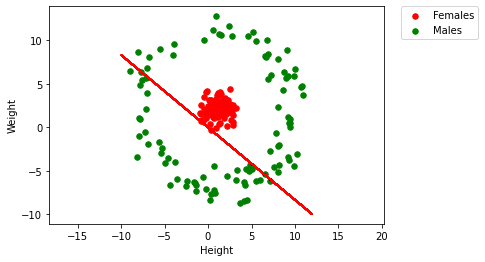

In [15]:
def plot_w(w,b):
    ylim = plt.axes().get_ylim()
    xlim = plt.axes().get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

plot_mf(X1,X2)
plot_w(w,b)

## Exercise 5 (in lab): "easy" non-separable data, Gaussian (RBF) kernel with non-overlapping data

Now use the Gaussian (radial basis function) kernel instead of the linear kernel implemented in the code above and verify that you can correctly
solve the problem.

In [16]:
#annulus data

# Generate data for class 1
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_smple = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2
angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# # Combine X1 and X2 into single dataset
# X = np.concatenate([X1, X2],axis = 0)
# y = np.append(np.zeros(num_sample),np.ones(num_sample))
# y = y.reshape(-1, 1)
X = np.concatenate([X1, X2],0);
y = np.concatenate([-np.matrix(np.ones([100,1])),np.matrix(np.ones([100,1]))]);


In [17]:
y = np.array(y)

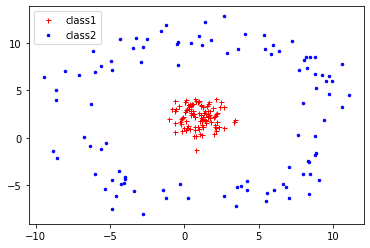

In [18]:
import matplotlib.pyplot as plt
def plotData(X, y):
    """Plots the data points X and y into a new figure """
    
    y = y.flatten()
    class1 = y==-1
    class2 = y==1
    plt.figure(figsize=(6,4))    
    plt.plot(X[:,0][class1], X[:,1][class1], "r+", markersize=5, label='class1')
    plt.plot(X[:,0][class2], X[:,1][class2], "b.", markersize=5, label='class2')
    plt.legend()
    # shorter but not as clear
    # plt.plot(X[:,0][pos], X[:,1][pos], 'k+', X[:,0][neg], X[:,1][neg], 'yo', markersize=15)  

plotData(X, y)

In [19]:
def visualizeBoundaryNonLinear(X, y, model):
    """Plots a non linear decision boundary learned by the SVM"""
    
    plt.figure(figsize=(10,8))
    plotData(X, y)
    X_21,X_22 = np.meshgrid(np.linspace(X[:,0].min(),X[:,1].max(),num=100),np.linspace(X[:,1].min(),X[:,1].max(),num=100))
    plt.contour(X_21,X_22,rbk_model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape),1,colors="k")
    plt.legend()
    plt.show()

<Figure size 720x576 with 0 Axes>

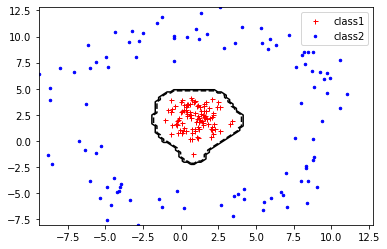

In [20]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC

rbk_model = SVC(kernel="rbf",gamma=1, C=100)
rbk_model.fit(X,y.ravel())
# plotting the decision boundary
visualizeBoundaryNonLinear(X, y, rbk_model)

Decision boundary can be made for such dataset with RBF kernel


## Exercise 6 (take home): more difficult non-separable data

Now find or generate a dataset in which the decision boundary is nonlinear AND the data overlap along that nonlinear boundary.
Show that the 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

mu = [[20,20], [16,16], [24,24]]
sigma_increase = [[10,9],[9,10]]
sigma_decrease = [[10,-9],[-9,10]]

num_of_clusters = 3
i = 0
c1 = np.random.multivariate_normal(mu[0], sigma_increase, 200)
c2 = np.random.multivariate_normal(mu[1], sigma_decrease, 200)
c3 = np.random.multivariate_normal(mu[2], sigma_decrease, 200)

X = np.append(c1,c2, axis = 0)
X = np.append(X,c3, axis = 0)

y1 = np.repeat(1,200)
y2 = np.repeat(2,200)
y3 = np.repeat(3,200)



In [22]:
X = np.concatenate([c1,c3],axis=0)

y = np.concatenate([y1,y2],axis=0)

In [23]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

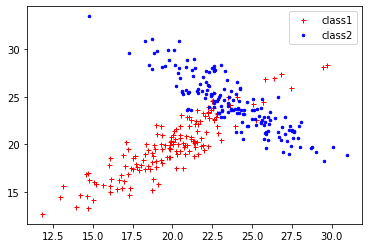

In [24]:
def plotData(X, y):
    """Plots the data points X and y into a new figure """
    
    y = y.flatten()
    class1 = y==1
    class2 = y==2
    plt.figure(figsize=(6,4))    
    plt.plot(X[:,0][class1], X[:,1][class1], "r+", markersize=5, label='class1')
    plt.plot(X[:,0][class2], X[:,1][class2], "b.", markersize=5, label='class2')
    plt.legend()
    # shorter but not as clear
    # plt.plot(X[:,0][pos], X[:,1][pos], 'k+', X[:,0][neg], X[:,1][neg], 'yo', markersize=15)  

plotData(X_train, y_train)


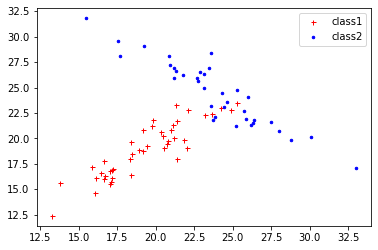

In [25]:
plotData(X_test, y_test)

In [26]:
def svmTrainLinear(X, y, C, kernelFunction, tol=1e-3, max_passes=-1, sigma=0.1):
    """Trains an SVM classifier"""    
    y = y.flatten()
    clf = svm.SVC(C = C, kernel=kernelFunction, tol=tol, max_iter=max_passes, verbose=2)
    return clf.fit(X, y)       

    
def visualizeBoundaryLinear(X, y, model):
    """Plots a linear decision boundary learned by the SVM"""
    
    plotData(X, y) 
    w = model.coef_[0]
    b = model.intercept_[0]
    xp = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yp = - (w[0] * xp + b) / w[1]
    plt.plot(xp, yp, 'b-')   
    plt.show()

[LibSVM]

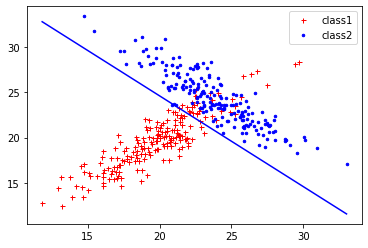

In [27]:
#Linear kernel
C = 0.1
linear_model = svmTrainLinear(X_train, y_train, C, "linear")
visualizeBoundaryLinear(X, y, linear_model)

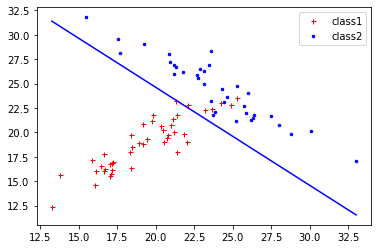

In [30]:
visualizeBoundaryLinear(X_test, y_test, linear_model)

<Figure size 720x576 with 0 Axes>

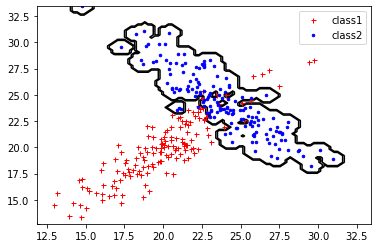

In [31]:
# Atttempting with a gaussian kernel(RBF)
def visualizeBoundaryNonLinear(X, y, model):
    """Plots a non linear decision boundary learned by the SVM"""
    
    plt.figure(figsize=(10,8))
    plotData(X, y)
    X_21,X_22 = np.meshgrid(np.linspace(X[:,0].min(),X[:,1].max(),num=100),np.linspace(X[:,1].min(),X[:,1].max(),num=100))
    plt.contour(X_21,X_22,rbk_model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape),1,colors="k")
    plt.legend()
    plt.show()
    
rbk_model = SVC(kernel="rbf",gamma=10, C=10)
rbk_model.fit(X_train,y_train.ravel())
# plotting the decision boundary
visualizeBoundaryNonLinear(X_train, y_train, rbk_model)

<Figure size 720x576 with 0 Axes>

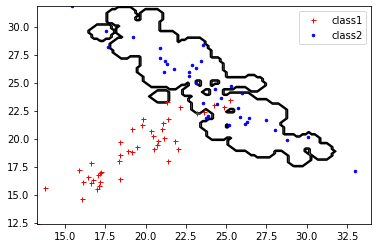

In [32]:
visualizeBoundaryNonLinear(X_test, y_test, rbk_model)